# Inshop data exploration

In [1]:
from fastai.vision.all import *
import seaborn as sns
import PIL.Image
warnings.filterwarnings("ignore")
plt.style.use("fivethirtyeight")

Read the dataframe and then have a look at the distribution of classes in the dataset

In [2]:
records = []
lines = Path("../data/list_eval_partition.txt").read_text().split("\n")
for line in lines[2:-1]:
    try:
        pth, cl, imtype = [x for x in line.split(" ") if x != ""]
        records.append([pth, cl, imtype])
    except Exception as e:
        print(line, str(e))
df = pd.DataFrame(records, columns = ["ImgPath", "Class", "ImgType"])

In [3]:
class_pivot = df.groupby(by = "Class").count().reset_index()
class_pivot.ImgPath.describe(percentiles = np.arange(0,1,0.05))

count    7982.000000
mean        6.603859
std         6.621219
min         1.000000
0%          1.000000
5%          3.000000
10%         3.000000
15%         4.000000
20%         4.000000
25%         4.000000
30%         4.000000
35%         4.000000
40%         4.000000
45%         4.000000
50%         5.000000
55%         5.000000
60%         5.000000
65%         5.000000
70%         7.000000
75%         8.000000
80%         8.000000
85%         9.000000
90%        12.000000
95%        15.000000
max       162.000000
Name: ImgPath, dtype: float64

Have a look at a few samples which have only one example, 4 examples, 8 examples per class and understand the distribution of the dataset

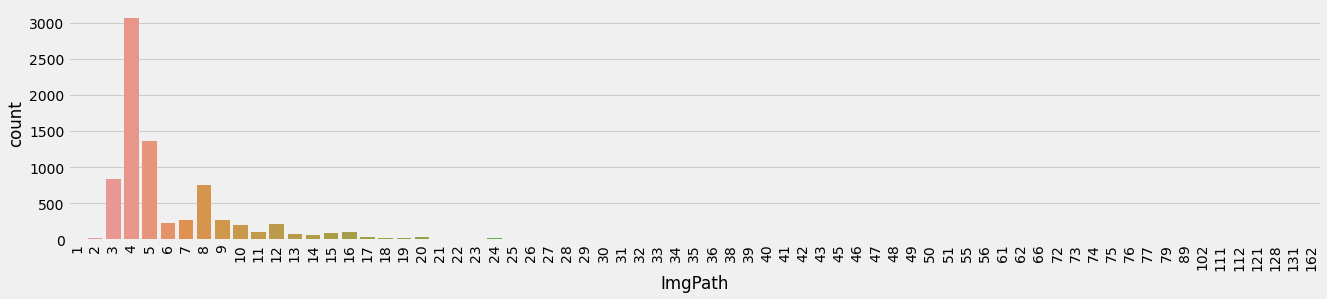

In [4]:
fig, ax = plt.subplots(1, 1, figsize = (20,4))
sns.countplot(class_pivot.ImgPath);
plt.xticks(rotation = 90);

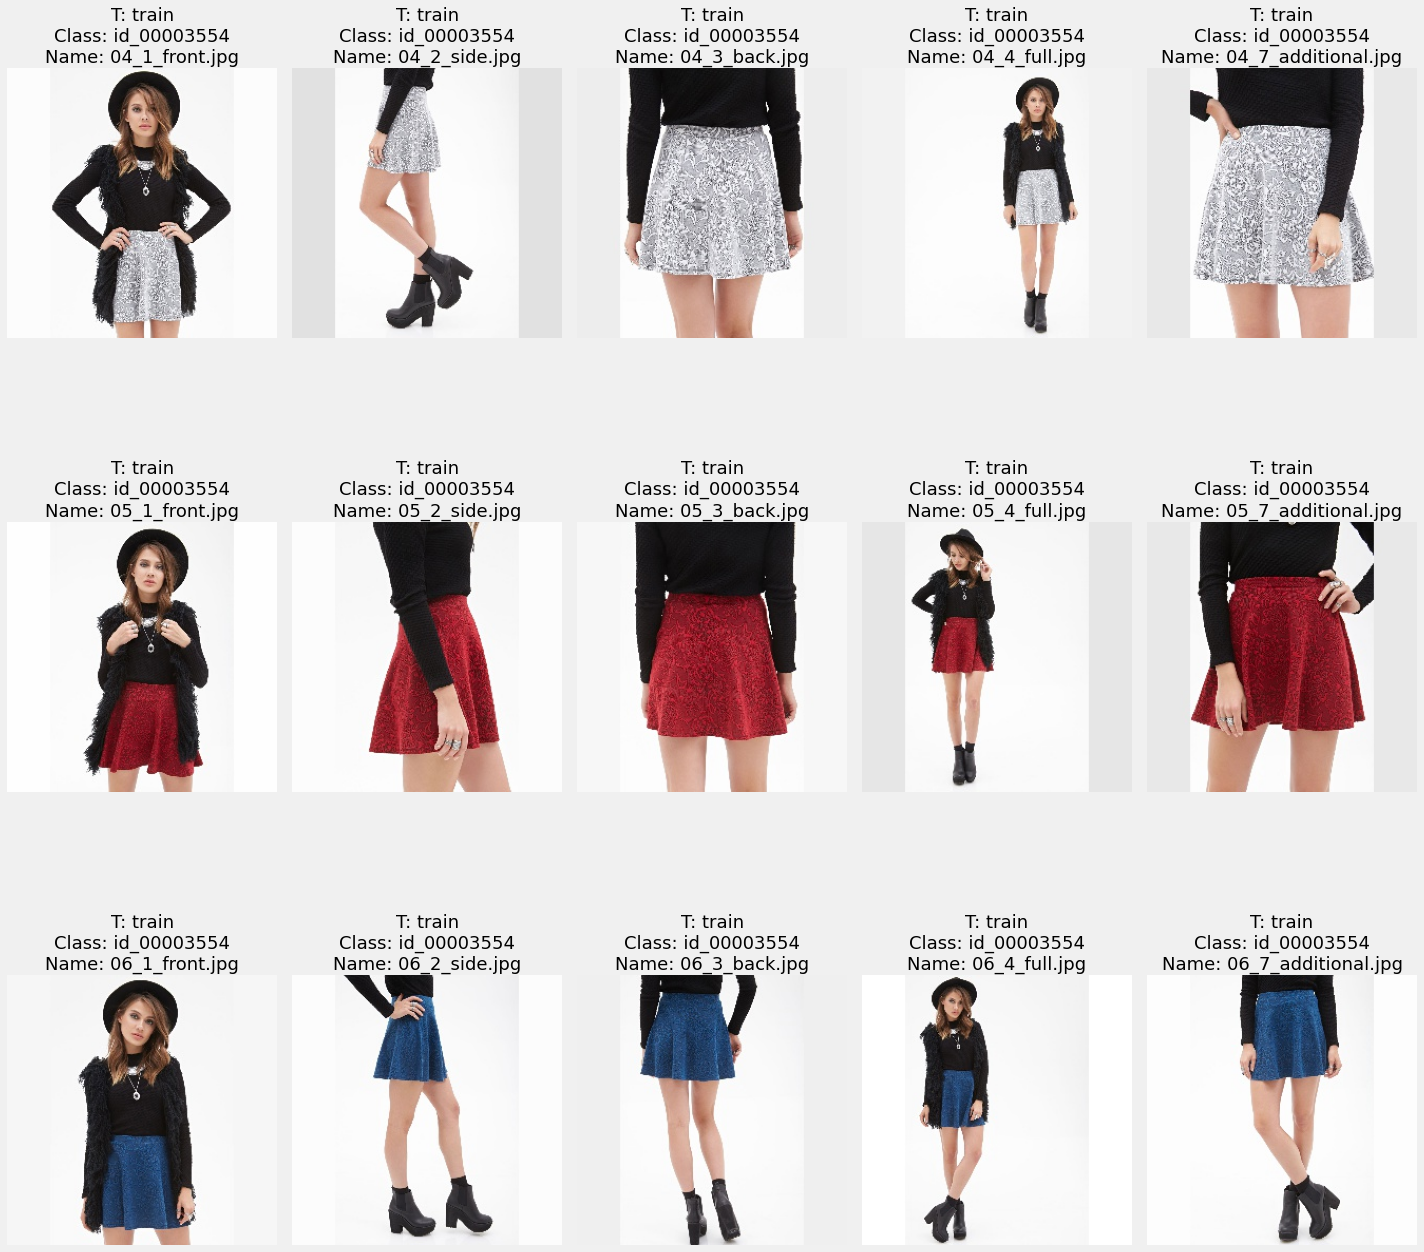

In [5]:
k = 15
products_k_views = class_pivot[class_pivot.ImgPath == k].Class.tolist()
product = random.choice(products_k_views)

fig, ax = plt.subplots(3, 5, figsize = (20,20))
ax = ax.flatten()

for entry in df[df.Class == product].reset_index(drop = True).itertuples():
    idx, pth, cl, itype = entry
    axis = ax[idx]
    axis.imshow(PIL.Image.open(f"../data/{pth}"))
    for spine_pos in ["right", "top", "left", "bottom"]: axis.spines[spine_pos].set_visible(False)
    axis.set_title(f"T: {itype}\nClass: {product}\nName: {Path(pth).name}", fontsize = 18)
    axis.set_xticks([]); axis.set_yticks([]);


fig.tight_layout();

My definition of class is slightly different from the definition of class which is given in the inshop dataset.

We can see above that the variants of a product are also grouped together in the same class. I want class to be defined only at a product or sku level. Thankfully due to the clever naming convention in the dataset, we can easily achieve this by doing the following.

1. Get all the images under a class
2. The name of images under a class have this nomenclature `{prd_id}_{number}_{orientation}.jpg`.
3. Split on the underscore for the image name and get the product id and append it with the existing class id to get the new class id.

In [6]:
def create_class_definition(row):
    pth = Path(row["ImgPath"])
    cl  = row["Class"]
    
    iname = pth.stem.split("_")[0]
    new_cls = f"{cl}_{iname}"
    return new_cls    

In [7]:
df["Actual_Class"] =  df.apply(lambda x: create_class_definition(x), axis = 1)

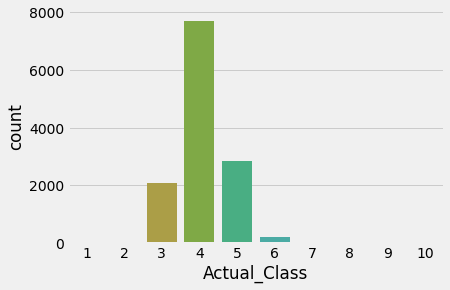

In [8]:
# Look at the counts of Actuual class values and only retain those which have at least 3 images
sns.countplot(x = df.Actual_Class.value_counts());

If there are less than 3 instances per class, it is very difficult for a classifier to learn the representation for this class. Let us filter these out and keep only those images which have more than 3 images per class.

In [9]:
tmp = df.Actual_Class.value_counts()
banned_classes = tmp[tmp < 3].index

In [10]:
filtered_df = df[df.Actual_Class.apply(lambda x: x not in banned_classes)].reset_index(drop = True)
filtered_df.tail()

,ImgPath,Class,ImgType,Actual_Class
52573,img/WOMEN/Jackets_Coats/id_00007982/12_7_additional.jpg,id_00007982,gallery,id_00007982_12
52574,img/WOMEN/Jackets_Coats/id_00007982/13_1_front.jpg,id_00007982,query,id_00007982_13
52575,img/WOMEN/Jackets_Coats/id_00007982/13_2_side.jpg,id_00007982,gallery,id_00007982_13
52576,img/WOMEN/Jackets_Coats/id_00007982/13_3_back.jpg,id_00007982,query,id_00007982_13
52577,img/WOMEN/Jackets_Coats/id_00007982/13_7_additional.jpg,id_00007982,query,id_00007982_13


Once this is done, let us now visualize the results with these new class ids and check how it's looking like.

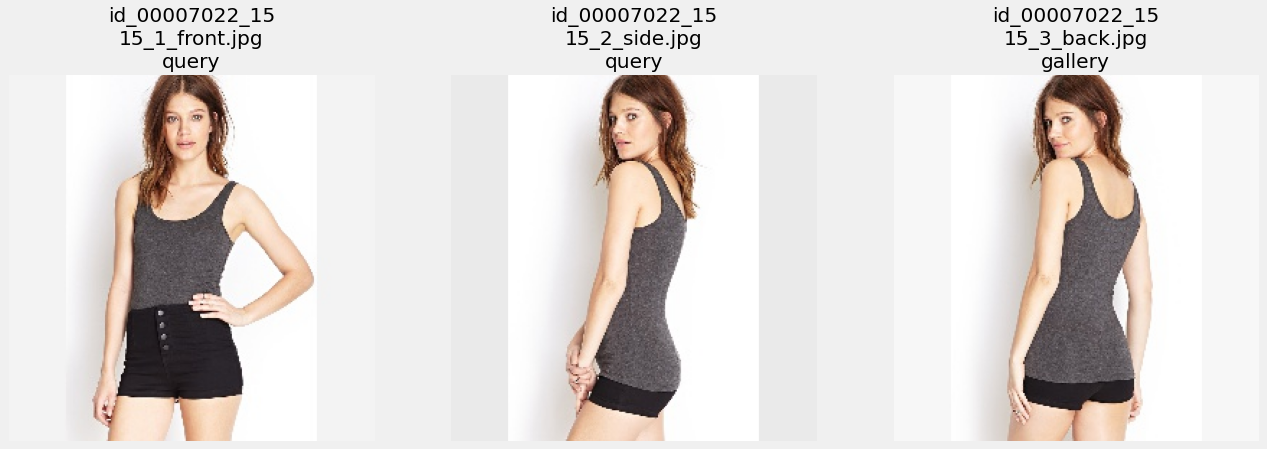

In [11]:
import PIL.Image
# Visualize a few images
actual_class = random.choice(filtered_df.Actual_Class.unique().tolist())
temp_df = filtered_df[filtered_df.Actual_Class == actual_class]

fig, ax = plt.subplots(1, len(temp_df), figsize = (20,20))
for record, axis in zip(temp_df.itertuples(), ax):
    axis.imshow(PIL.Image.open(f"../data/{record[1]}"))
    axis.set_xticks([]); axis.set_yticks([]);
    axis.set_title(f"{record[-1]}\n{Path(record[1]).name}\n{record[3]}")

Check if there are any images that are only in query or only in gallery. 

We will have to drop the images which are only in query to get meaningful validation results.

For those which are only in gallery, we can move some of them into query and then balance it out. Let us investigate.

In [12]:
img_types = filtered_df.groupby(by = "Actual_Class")["ImgType"].apply(lambda x: ",".join(x)).reset_index()

For every class which is in query and gallery, check the distribution of how many images of that class are in query and how many images are in the gallery set. This will help us understand the complexity of retrieval; especially the count of images in the gallery set per class.

In [13]:
l1_fltr = img_types.ImgType.apply(lambda x: Counter(x.split(",")))
img_types["Gallery_Count"] = l1_fltr.apply(lambda x: x["gallery"] if "gallery" in x else 0)
img_types["Query_Count"] = l1_fltr.apply(lambda x: x["query"] if "query" in x else 0)
img_types["Train_Count"] = l1_fltr.apply(lambda x: x["train"] if "train" in x else 0)

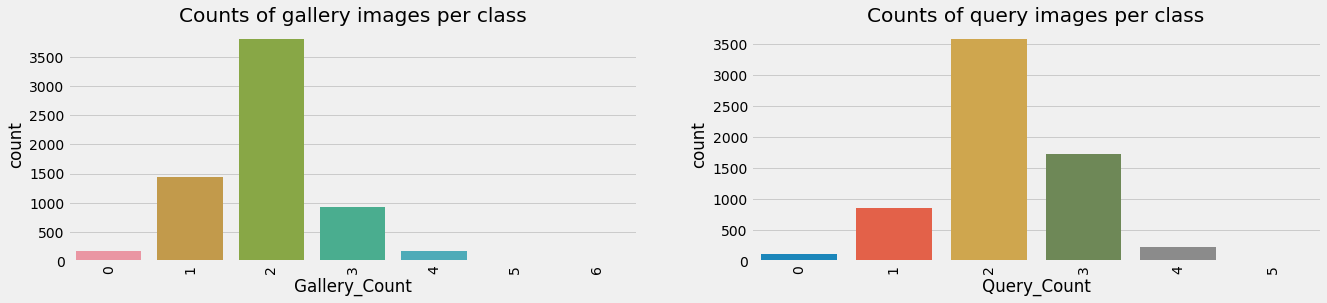

In [14]:
query_gallery_df = img_types[img_types.Train_Count == 0].reset_index(drop = True)

fig, ax = plt.subplots(1, 2, figsize = (20,4))
sns.countplot(query_gallery_df.Gallery_Count, ax = ax[0])
sns.countplot(query_gallery_df.Query_Count, ax = ax[1])
ax[0].set_title("Counts of gallery images per class")
ax[1].set_title("Counts of query images per class")
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation = 90); ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation = 90);

We can see that there is a small proportion of images only in gallery and a small proportion of images only in query. Let us investigate.

In [15]:
query_gallery_df[query_gallery_df.Gallery_Count == 0]

,Actual_Class,ImgType,Gallery_Count,Query_Count,Train_Count
43,id_00000074_04,"query,query,query",0,3,0
66,id_00000099_07,"query,query,query,query",0,4,0
92,id_00000135_08,"query,query,query,query",0,4,0
147,id_00000212_02,"query,query,query,query",0,4,0
191,id_00000284_02,"query,query,query",0,3,0
...,...,...,...,...,...
6412,id_00007840_11,"query,query,query,query",0,4,0
6453,id_00007893_03,"query,query,query",0,3,0
6457,id_00007896_08,"query,query,query,query",0,4,0
6464,id_00007903_08,"query,query,query,query",0,4,0


In [16]:
query_gallery_df[query_gallery_df.Gallery_Count == 0].Query_Count.describe()

count    168.000000
mean       3.636905
std        0.540853
min        3.000000
25%        3.000000
50%        4.000000
75%        4.000000
max        5.000000
Name: Query_Count, dtype: float64

In [17]:
query_gallery_df[query_gallery_df.Query_Count == 0].Gallery_Count.describe()

count    119.000000
mean       3.672269
std        0.625845
min        3.000000
25%        3.000000
50%        4.000000
75%        4.000000
max        6.000000
Name: Gallery_Count, dtype: float64

It can be seen that in case where query count is zero, there are at least three images in the gallery set for the corresponding class and in case where gallery count is zero, there are at least three images in the query set. 

This will be problematic in image retrieval because we will be searching for something in the inventory for a sku which doesn't exist wrt these particular set of classes. To solve this, what we could do is as follows:

1. Randomly sample one image to belong to query and remaining to gallery set from the df where query_count = 0
2. Randomly select one image to stay in query and move remaining to gallery set from the df where gallery_count = 0

Once this is done, replot the query_gallery df plot to ascertain whether the method has worked or not.

In [18]:
imgtype_list = filtered_df.ImgType.tolist()

for cl in query_gallery_df[query_gallery_df.Gallery_Count == 0].Actual_Class.tolist():
    idxs = filtered_df[filtered_df.Actual_Class == cl].index.tolist()
    for j in idxs[1:]:
        imgtype_list[j] = "gallery"

for cl in query_gallery_df[query_gallery_df.Query_Count == 0].Actual_Class.tolist():
    idxs = filtered_df[filtered_df.Actual_Class == cl].index.tolist()
    imgtype_list[idxs[0]] = "query"

filtered_df = deepcopy(filtered_df)
filtered_df["ImgType"] = imgtype_list

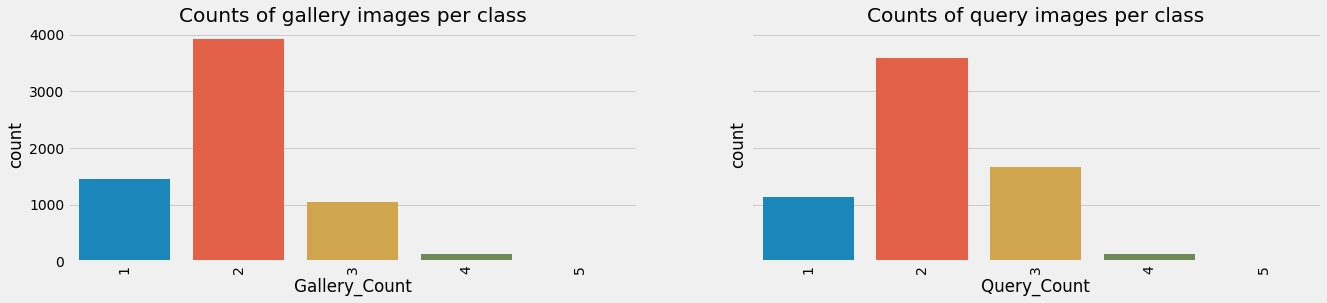

In [19]:
img_types = filtered_df.groupby(by = "Actual_Class")["ImgType"].apply(lambda x: ",".join(x)).reset_index()

l1_fltr = img_types.ImgType.apply(lambda x: Counter(x.split(",")))
img_types["Gallery_Count"] = l1_fltr.apply(lambda x: x["gallery"] if "gallery" in x else 0)
img_types["Query_Count"] = l1_fltr.apply(lambda x: x["query"] if "query" in x else 0)
img_types["Train_Count"] = l1_fltr.apply(lambda x: x["train"] if "train" in x else 0)

query_gallery_df = img_types[img_types.Train_Count == 0].reset_index(drop = True)

fig, ax = plt.subplots(1, 2, figsize = (20,4), sharey = True)
sns.countplot(query_gallery_df.Gallery_Count, ax = ax[0])
sns.countplot(query_gallery_df.Query_Count, ax = ax[1])
ax[0].set_title("Counts of gallery images per class")
ax[1].set_title("Counts of query images per class")
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation = 90); ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation = 90);

We now have an evaluation set where each query item has at least one neighbour in the gallery set. This makes the evaluation set complete.

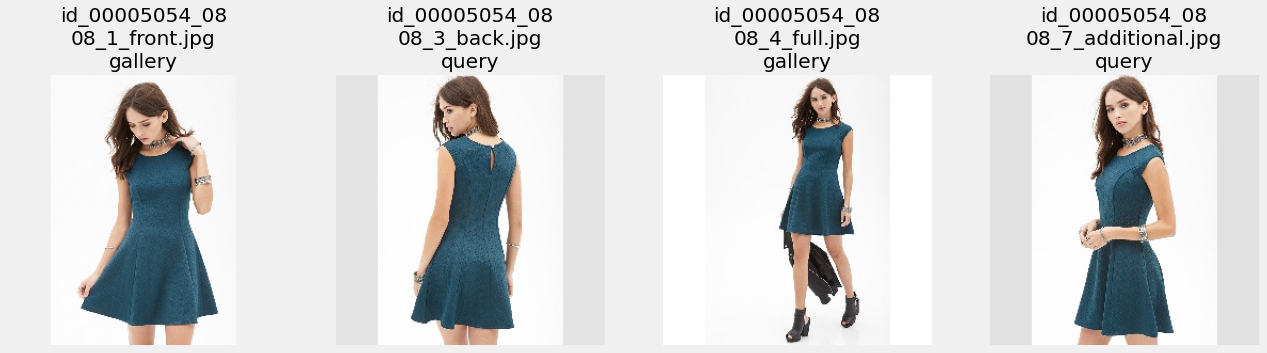

In [20]:
# Randomly look at some evaluation samples
actual_class = query_gallery_df.Actual_Class.sample(1).item()

import PIL.Image
temp_df = filtered_df[filtered_df.Actual_Class == actual_class]

fig, ax = plt.subplots(1, len(temp_df), figsize = (20,20))
for record, axis in zip(temp_df.itertuples(), ax):
    axis.imshow(PIL.Image.open(f"../data/{record[1]}"))
    axis.set_xticks([]); axis.set_yticks([]);
    axis.set_title(f"{record[-1]}\n{Path(record[1]).name}\n{record[3]}")

In [21]:
# Number of records lost due to our preprocessing
len(df) - len(filtered_df), round(100 * (len(df) - len(filtered_df)) / len(df), 4)

(134, 0.2542)

We can see that we lost 134 out of 52k samples which is around 0.25% of the entire training set due to our processing, which is fine. But we also made sure that the data is in a form which we appreciate and gained much more finegrained understanding about it.

Classes: 6315


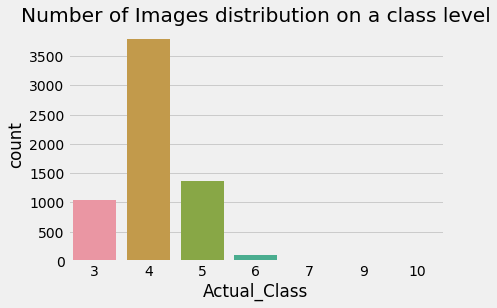

In [36]:
# Let us also quickly understand how many training classes are there and the number of total classes (here each product is a class and has at least 2 images in the dataset
temp = filtered_df[filtered_df.ImgType == "train"].Actual_Class.value_counts().reset_index()
print(f"Classes: {len(temp)}")
sns.countplot(temp.Actual_Class);
plt.title("Number of Images distribution on a class level");

So, in training we have around 6315 products and most products have around 4 images per class. Some of them have more than 5, but they are very few in number... The following cell demonstrates such examples but they are really scarce.

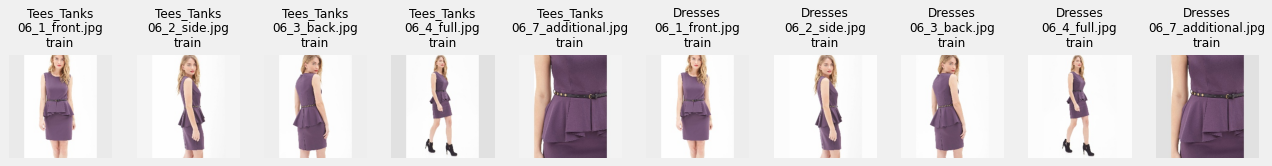

In [66]:
# Randomly look at some evaluation samples
actual_class = temp[temp.Actual_Class > 6].sample(1).iloc[:,0].item()

import PIL.Image
temp_df = filtered_df[filtered_df.Actual_Class == actual_class]
fig, ax = plt.subplots(1, len(temp_df), figsize = (20,20))
for record, axis in zip(temp_df.itertuples(), ax):
    axis.imshow(PIL.Image.open(f"../data/{record[1]}"))
    axis.set_xticks([]); axis.set_yticks([]);
    axis.set_title(f"{Path(record[1]).parent.parent.name}\n{Path(record[1]).name}\n{record[3]}", fontsize = 12)

It is clear that the entries which have more than 6 datapoints per class are truly speaking duplicated i.e. since they belong to multiple categories, they have been encountered more than once in the dataframe and hence we are getting that number.

This means actual counts of images per class is really around 4-5 images on an average.

In [68]:
# Save the processed dataframe to a csv.
filtered_df.to_csv("../data/final_explored_df_retrieval.csv", index = False)

# Attribute Exploration

In [22]:
filtered_df[filtered_df.Class == "id_00007982"]

,ImgPath,Class,ImgType,Actual_Class
52566,img/WOMEN/Jackets_Coats/id_00007982/11_1_front.jpg,id_00007982,gallery,id_00007982_11
52567,img/WOMEN/Jackets_Coats/id_00007982/11_2_side.jpg,id_00007982,gallery,id_00007982_11
52568,img/WOMEN/Jackets_Coats/id_00007982/11_3_back.jpg,id_00007982,query,id_00007982_11
52569,img/WOMEN/Jackets_Coats/id_00007982/11_7_additional.jpg,id_00007982,query,id_00007982_11
52570,img/WOMEN/Jackets_Coats/id_00007982/12_1_front.jpg,id_00007982,query,id_00007982_12
52571,img/WOMEN/Jackets_Coats/id_00007982/12_2_side.jpg,id_00007982,gallery,id_00007982_12
52572,img/WOMEN/Jackets_Coats/id_00007982/12_3_back.jpg,id_00007982,gallery,id_00007982_12
52573,img/WOMEN/Jackets_Coats/id_00007982/12_7_additional.jpg,id_00007982,gallery,id_00007982_12
52574,img/WOMEN/Jackets_Coats/id_00007982/13_1_front.jpg,id_00007982,query,id_00007982_13
52575,img/WOMEN/Jackets_Coats/id_00007982/13_2_side.jpg,id_00007982,gallery,id_00007982_13


In [23]:
attribute_names = [x for x in Path("../data/list_attr_cloth.txt").read_text().split("\n")[2:] if x != ""]

In [24]:
len(attribute_names)

463

In [25]:
lines = [x for x in Path("../data/list_attr_items.txt").read_text().split("\n")[2:] if x != ""]

In [26]:
records = []
for l in lines:
    items = l.split(" ")
    record_name = items[0]
    attrs = []
    for idx, attribute in enumerate(items[1:]):
        if attribute == "1":
            attrs.append(attribute_names[idx])
    attrs = ",".join(attrs)
    records.append([record_name, attrs])
df = pd.DataFrame(records, columns = ["ImgName", "Attributes"]).drop_duplicates(subset = "ImgName").reset_index(drop = True)

In [27]:
df.head(3)

,ImgName,Attributes
0,id_00000001,"lightweight,polyester,woven,unlined,top,lined,buttoned,shoulder,button,sheer,cuffs,shoulders,light,line,geo"
1,id_00000002,"lightweight,woven,unlined,rayon,print,dress,lined,fit,round,buttoned,floral,neck,warm,button,outfit,oversized,sandals,slip,warm-weather,cute,slit,light,vibrant,fitted,line"
2,id_00000003,"lightweight,polyester,woven,rayon,classic,lined,lining,zipper,skirt,zip,leather,effortless,polished,crisp,white,refined,light,structured,polish,a-line,bright,mini,line,aesthetic,pleats"
